In [2]:
import numpy as np

import jax
import jax.numpy as jnp

from kernel_sca_inducing_points import *

In [4]:
A = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/A_softNormMax_centerFalse.npy')
X = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/X_softNormMax_centerFalse.npy')
K, N, T = X.shape

params = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/params_3d_linear.npy', allow_pickle=True).tolist()

kernel_function = K_X_Y_identity
d = 3
c = 30
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, H_K_A_u, alpha  = get_alpha(params, A, X, kernel_function, d)
alpha_tilde, u, l2, scale = get_params(params, kernel_function=kernel_function)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)
# plt.figure()
# plot_3D(Y)
# plt.title(compute_S_all_pairs(Y))
print(compute_S_all_pairs(Y))

0.35549787


In [22]:
K_A_A = kernel_function(A, A, l2=l2, scale=scale)

In [23]:
K_A_A.shape

(60235, 60235)

In [5]:


def var_explained_kernel(K_u_u, H_K_A_u, alpha_tilde, kernel_function, A, X, l2, scale, c):
    K, _, T = X.shape
    L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-5)
    print('L done')
    Q_, R = jnp.linalg.qr(H_K_A_u, mode='reduced')       
    print('QR done')                                                                                
    alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde, mode='reduced') 
    alpha = jnp.einsum('ij,jm->im', Q_, solve_triangular(R.T, jnp.dot(L, alpha_tilde_QR), lower=True))   
    print('alpha done')               

    K_A_A = kernel_function(A, A, l2=l2, scale=scale)
    print('K_A_A done')
    K_A_A_reshaped = K_A_A.reshape(K, T, K, T)
    print('K_A_A_reshaped done')
    mean = jnp.mean(K_A_A_reshaped, axis=(0,2), keepdims=True)   
    print('mean done')
    K_A_A_tilde = (K_A_A_reshaped - mean).reshape(K*T, K*T)       
    print('K_A_A_tilde done')

    var_explained = jnp.trace(alpha.T @ K_A_A_tilde @ K_A_A_tilde @ alpha) / jnp.trace(K_A_A_tilde)
    return var_explained


var_explained_kernel(K_u_u, H_K_A_u, alpha_tilde, kernel_function, A, X, l2, scale, c)

L done
QR done
alpha done
K_A_A done
K_A_A_reshaped done
mean done
K_A_A_tilde done


Array(0.3046044, dtype=float32)

In [13]:
X_reshaped = X.swapaxes(1,2).reshape(-1, N)
full_X_var = jnp.sum(jnp.var(X_reshaped, axis=0))

Y_reshaped = Y.swapaxes(1,2).reshape(-1, d)
full_Y_var = jnp.sum(jnp.var(Y_reshaped, axis=0))

full_Y_var/full_X_var

Array(0.21919909, dtype=float32)

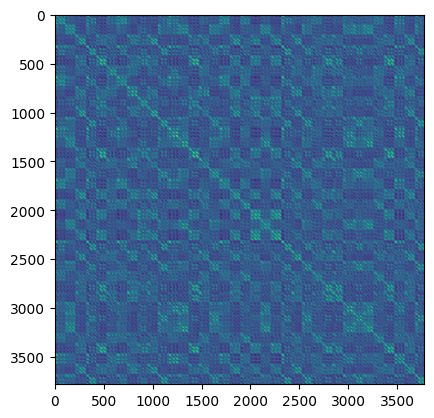

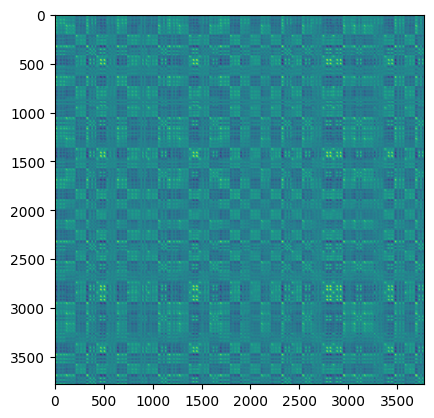

In [20]:
plt.imshow(K_A_A_tilde)

plt.figure()
plt.imshow(H_K_A_u @ K_u_u @ H_K_A_u.T )

In [19]:
K, _, T = X.shape
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-5)
Q_, R = jnp.linalg.qr(H_K_A_u, mode='reduced')                                                                                       
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde, mode='reduced') 
alpha = jnp.einsum('ij,jm->im', Q_, solve_triangular(R.T, jnp.dot(L, alpha_tilde_QR), lower=True))   
K_A_A = kernel_function(A, A, l2=l2, scale=scale)
K_A_A_reshaped = K_A_A.reshape(K, T, K, T)
mean = jnp.mean(K_A_A_reshaped, axis=(0,2), keepdims=True)   
K_A_A_tilde = (K_A_A_reshaped - mean).reshape(K*T, K*T)       

KK = (H_K_A_u @ K_u_u @ H_K_A_u.T @ H_K_A_u @ K_u_u @ H_K_A_u.T)
np.trace(alpha.T @ KK @ alpha ) / np.trace(KK)

0.00043368974

In [8]:
def var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u):
    return  np.trace( K_u_u_K_u_A_alpha_H.T @ H_K_A_u @ K_u_u @ H_K_A_u.T @ K_u_u_K_u_A_alpha_H / np.trace(H_K_A_u @ K_u_u @ H_K_A_u.T )   ) 

print(var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u))

TypeError: dot_general requires contracting dimensions to have the same shape, got (30,) and (3780,).